Each TFRecord file (batch_XXXX.tfrecord) contains:

Branch 1 (Geodata):
- window: Shape [64, 96, N_features] (batch_size, timesteps, features)
  * 64 observations per batch
  * 96 timesteps (24 hours at 15-min resolution)
  * N features (SME, SML, SMU, etc.)
- timestamp: Unix timestamp for each observation
- lookback: 96 (number of timesteps)
- num_features: N (number of features)

Branch 2 (SECS):
- window: Shape [64, 180, 20, 20, 3] (batch_size, timesteps, height, width, channels)
  * 64 observations per batch
  * 180 timesteps (3 hours at 1-min resolution)
  * 20x20 spatial grid
  * 3 RGB channels
- timestamp: Unix timestamp for each observation
- lookback: 180 (number of timesteps)
- height, width: 20, 20
- channels: 3

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import random
import os

In [2]:
# 1. Set up paths first
base_dir = '/Users/akv020/Tensorflow/fennomag-net/data/processed'
split = 'val'  # or 'train' or 'test'

In [3]:
# 2. Get file lists for both branches
branch1_files = sorted(tf.io.gfile.glob(os.path.join(base_dir, 'branch1', split, '*.tfrecord')))
branch2_files = sorted(tf.io.gfile.glob(os.path.join(base_dir, 'branch2', split, '*.tfrecord')))


In [4]:

# 3. Print info about available files
print("Looking for files in:")
print(f"Branch 1: {os.path.join(base_dir, 'branch1', split)}")
print(f"Branch 2: {os.path.join(base_dir, 'branch2', split)}")
print(f"\nFound {len(branch1_files)} files for Branch 1")
print(f"Found {len(branch2_files)} files for Branch 2")


Looking for files in:
Branch 1: /Users/akv020/Tensorflow/fennomag-net/data/processed/branch1/val
Branch 2: /Users/akv020/Tensorflow/fennomag-net/data/processed/branch2/val

Found 82 files for Branch 1
Found 82 files for Branch 2


In [5]:
# 4. Define parsing functions
def parse_tfrecord_branch1(example_proto):
    """Parse Branch 1 (geodata) TFRecord."""
    feature_description = {
        'window': tf.io.VarLenFeature(tf.float32),
        'timestamp': tf.io.FixedLenFeature([], tf.int64),
        'lookback': tf.io.FixedLenFeature([], tf.int64),
        'num_features': tf.io.FixedLenFeature([], tf.int64)
    }
    
    example = tf.io.parse_single_example(example_proto, feature_description)
    
    # Convert sparse tensor to dense and reshape
    window = tf.sparse.to_dense(example['window'])
    window = tf.reshape(window, [96, 16])  # [lookback, num_features]
    
    return window, example['timestamp']

In [9]:
def parse_tfrecord_branch2(example_proto):
    """Parse Branch 2 (SECS) TFRecord."""
    feature_description = {
        'window': tf.io.VarLenFeature(tf.float32),
        'timestamp': tf.io.FixedLenFeature([], tf.int64),
        'lookback': tf.io.FixedLenFeature([], tf.int64),
        'height': tf.io.FixedLenFeature([], tf.int64),
        'width': tf.io.FixedLenFeature([], tf.int64),
        'channels': tf.io.FixedLenFeature([], tf.int64)
    }
    
    example = tf.io.parse_single_example(example_proto, feature_description)
    
    # Get the dimensions
    lookback = tf.cast(example['lookback'], tf.int32)
    height = tf.cast(example['height'], tf.int32)
    width = tf.cast(example['width'], tf.int32)
    channels = tf.cast(example['channels'], tf.int32)
    
    # Convert sparse tensor to dense and reshape
    window = tf.sparse.to_dense(example['window'])
    window = tf.reshape(window, [lookback, height, width, channels])  # Now using actual dimensions
    
    return window, example['timestamp']

In [10]:
# 5. Define loading function
def load_and_display_batch(batch_idx):
    """Load and display a batch of data from both branches."""
    print(f"\nLoading batch file:")
    print(f"Branch 1: {branch1_files[batch_idx]}")
    print(f"Branch 2: {branch2_files[batch_idx]}")
    
    # Load the data
    branch1_dataset = tf.data.TFRecordDataset(branch1_files[batch_idx]).map(parse_tfrecord_branch1)
    branch2_dataset = tf.data.TFRecordDataset(branch2_files[batch_idx]).map(parse_tfrecord_branch2)
    
    # Convert to lists
    branch1_batch = list(branch1_dataset)
    branch2_batch = list(branch2_dataset)
    
    print(f"\nLoaded {len(branch1_batch)} observations from each branch")
    
    # Display shapes
    print("\nBranch 1 (geodata) shape:", branch1_batch[0][0].shape)
    print("Branch 2 (SECS) shape:", branch2_batch[0][0].shape)
    
    return branch1_batch, branch2_batch

In [11]:
# 6. Try loading a batch
batch_idx = random.randint(0, len(branch1_files) - 1)
print(f"\nSelected batch {batch_idx + 1} of {len(branch1_files)}")
branch1_batch, branch2_batch = load_and_display_batch(batch_idx)


Selected batch 82 of 82

Loading batch file:
Branch 1: /Users/akv020/Tensorflow/fennomag-net/data/processed/branch1/val/batch_0081.tfrecord
Branch 2: /Users/akv020/Tensorflow/fennomag-net/data/processed/branch2/val/batch_0081.tfrecord

Loaded 64 observations from each branch

Branch 1 (geodata) shape: (96, 16)
Branch 2 (SECS) shape: (180, 21, 21, 3)


Visualizing random examples from the batch...


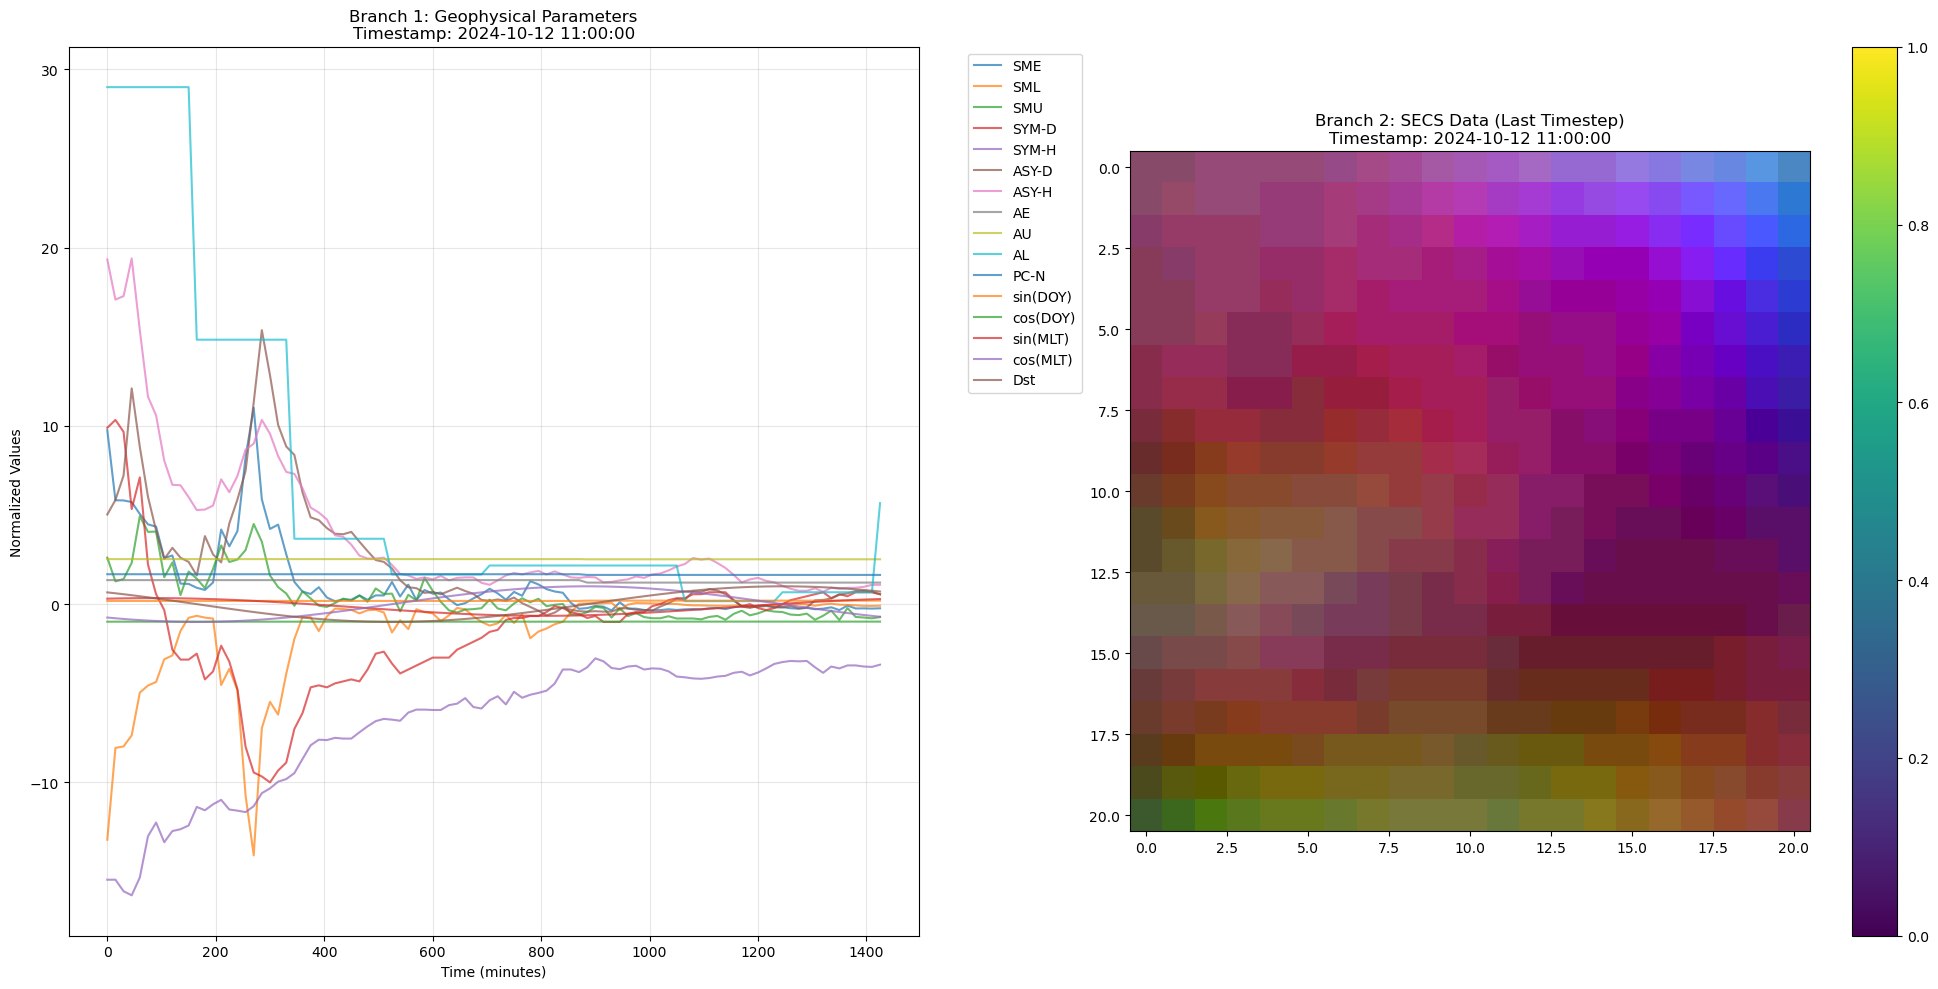


Statistics for example 38 (Timestamp: 2024-10-12 11:00:00):
Branch 1 (Geodata):
  Range: [-16.333, 29.000]
  Mean: 0.562
  Std: 4.142

Branch 2 (SECS):
  Range: [0.459, 0.545]
  Mean: 0.499
  Std: 0.011




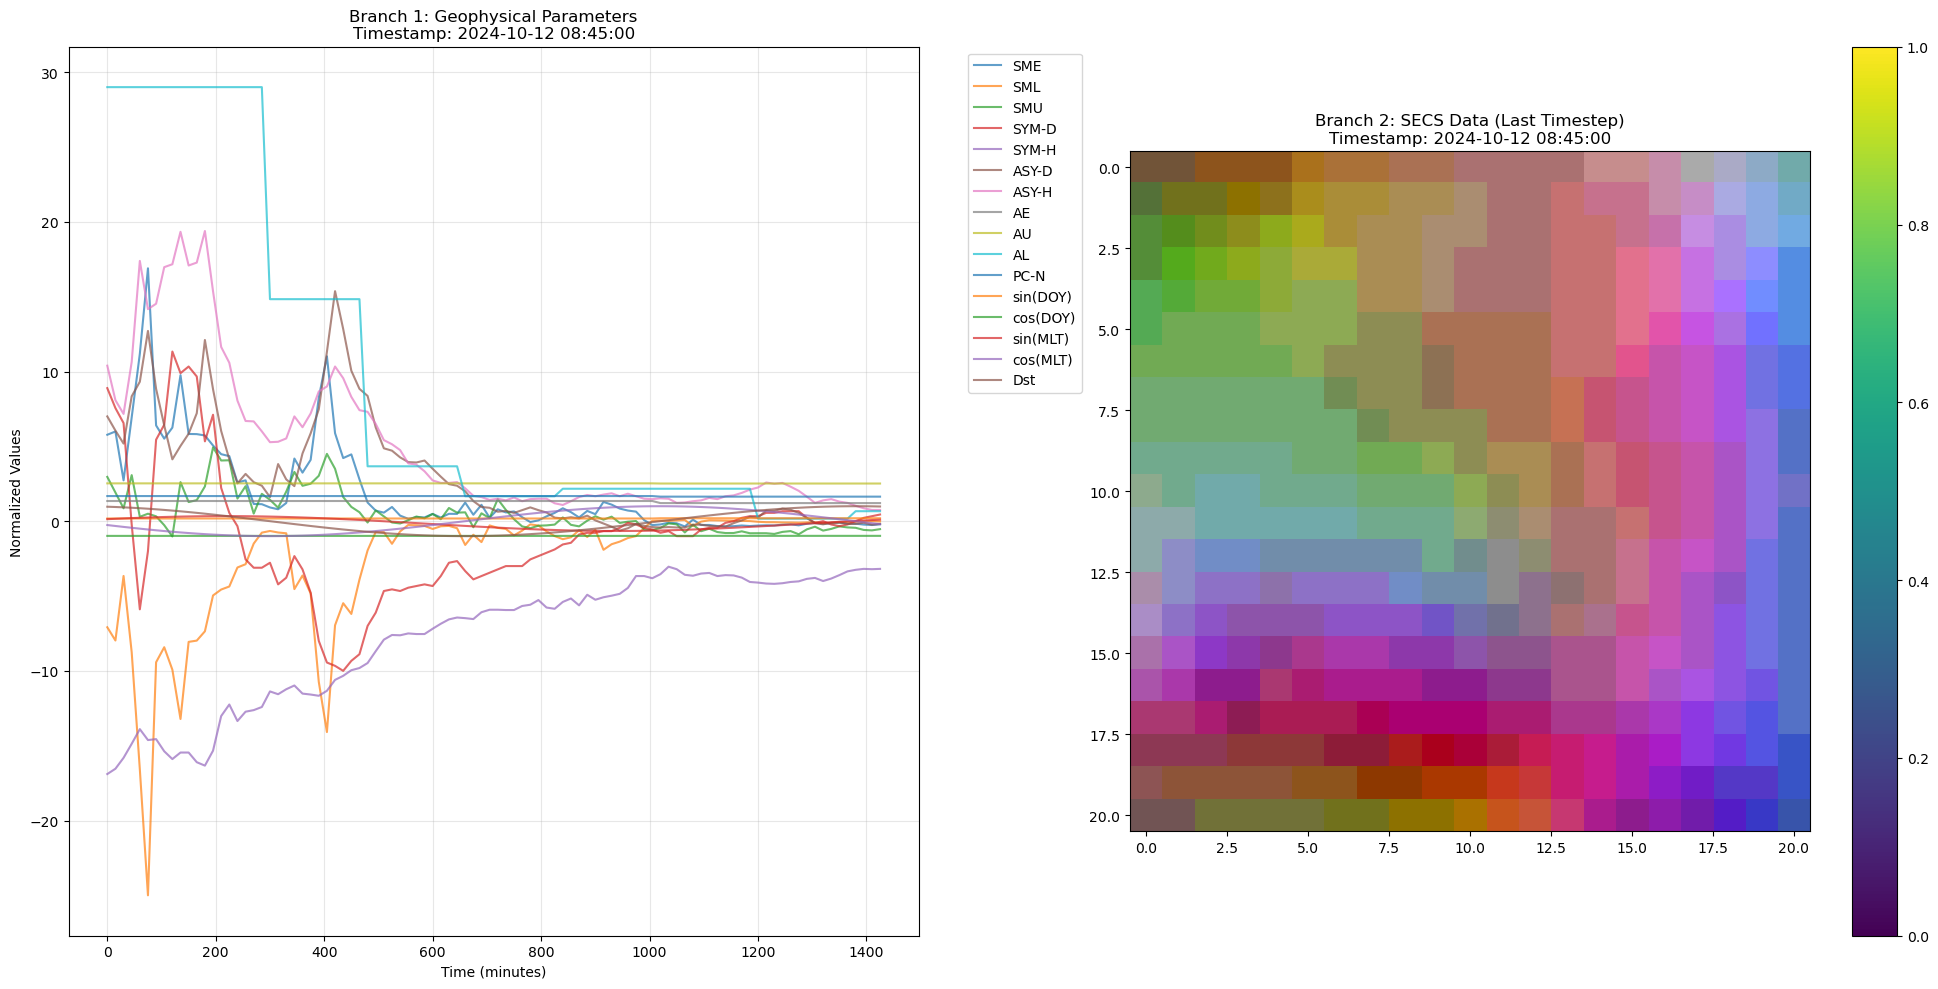


Statistics for example 37 (Timestamp: 2024-10-12 08:45:00):
Branch 1 (Geodata):
  Range: [-24.998, 29.000]
  Mean: 0.782
  Std: 5.109

Branch 2 (SECS):
  Range: [0.463, 0.537]
  Mean: 0.500
  Std: 0.007




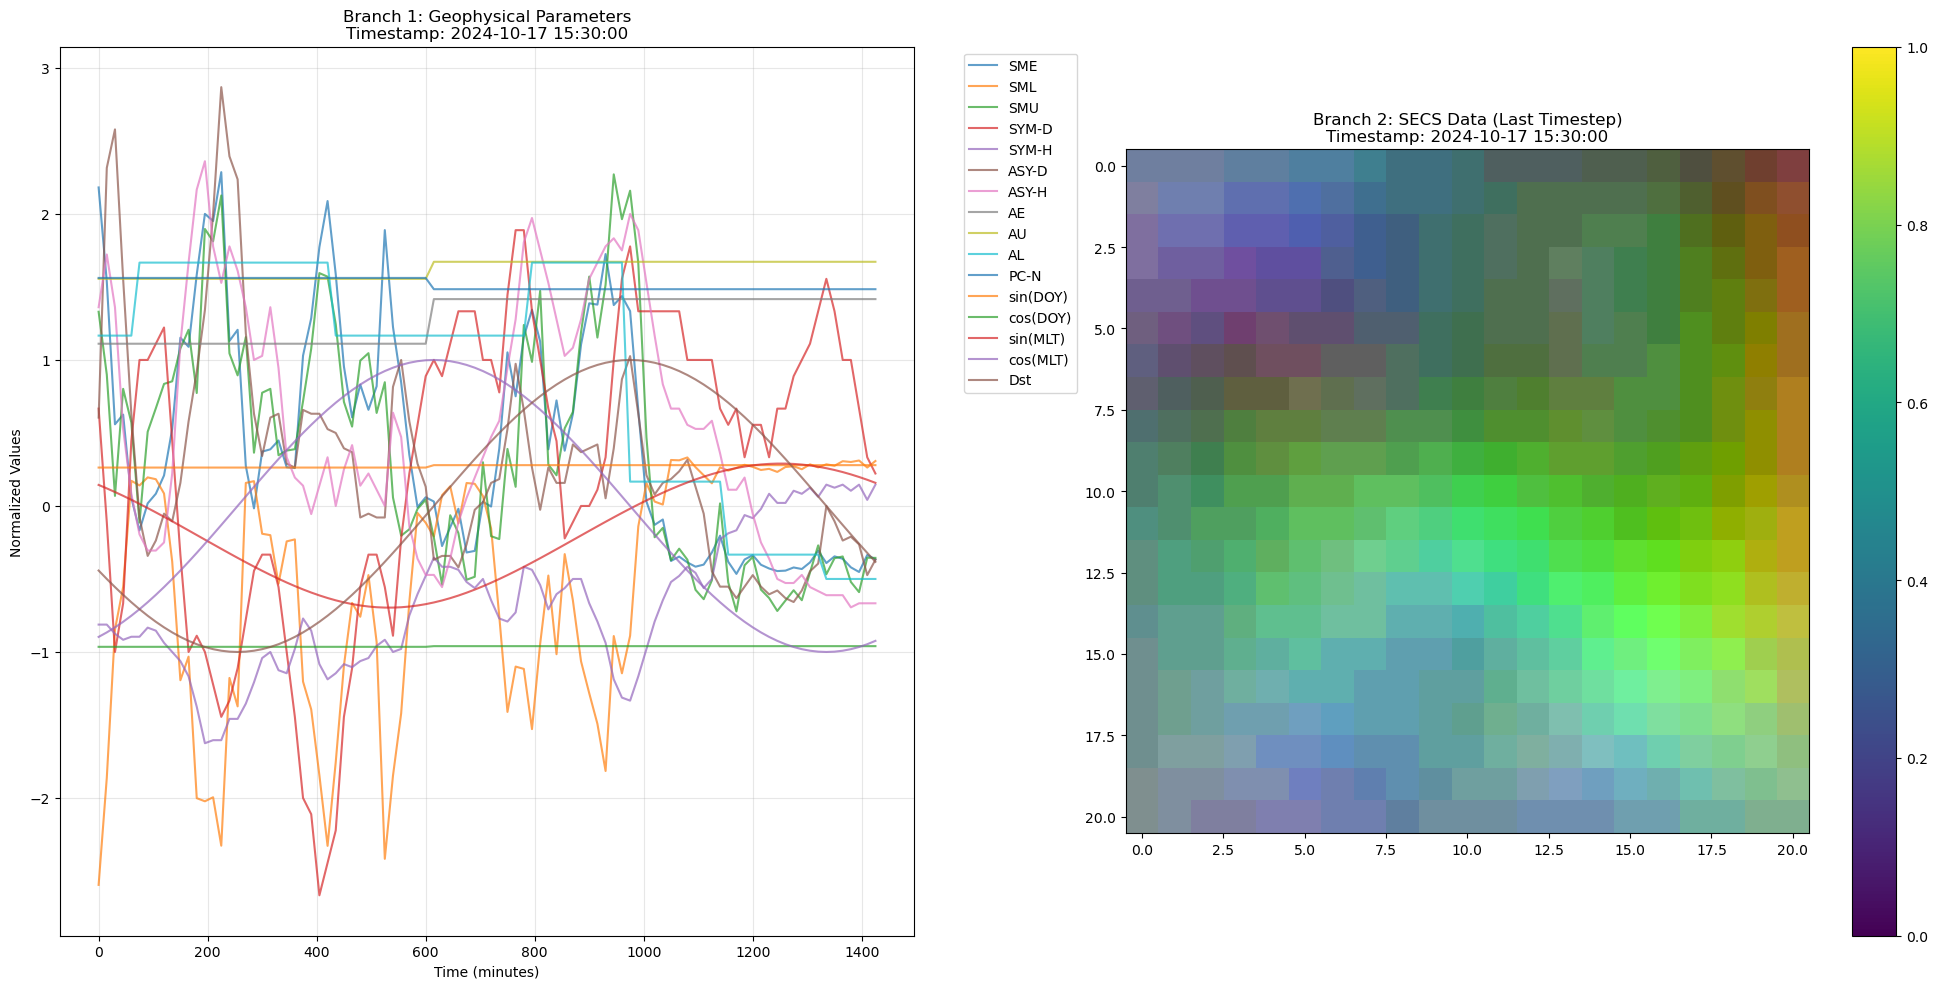


Statistics for example 43 (Timestamp: 2024-10-17 15:30:00):
Branch 1 (Geodata):
  Range: [-2.667, 2.868]
  Mean: 0.325
  Std: 0.954

Branch 2 (SECS):
  Range: [0.463, 0.529]
  Mean: 0.496
  Std: 0.010




In [13]:
def visualize_batch(branch1_batch, branch2_batch, num_examples=3):
    """
    Visualize random examples from both branches with timestamps.
    Branch 1 is shown as time series, Branch 2 as image.
    """
    # Select random indices
    batch_size = len(branch1_batch)
    indices = random.sample(range(batch_size), min(num_examples, batch_size))
    
    # Feature names for Branch 1 (if you have different names, please update these)
    feature_names = [
        'SME', 'SML', 'SMU', 'SYM-D', 'SYM-H', 
        'ASY-D', 'ASY-H', 'AE', 'AU', 'AL', 
        'PC-N', 'sin(DOY)', 'cos(DOY)', 'sin(MLT)', 'cos(MLT)', 'Dst'
    ]
    
    for idx in indices:
        # Get data for both branches
        geo_data, geo_ts = branch1_batch[idx]
        secs_data, secs_ts = branch2_batch[idx]
        
        # Convert timestamps to datetime
        timestamp = datetime.fromtimestamp(geo_ts.numpy())
        
        # Create time points (96 steps of 15 minutes each)
        time_points = np.arange(96) * 15  # minutes
        
        # Create figure with subplots
        fig = plt.figure(figsize=(20, 10))
        
        # 1. Branch 1 (Geodata) visualization as time series
        ax1 = plt.subplot(1, 2, 1)
        geo_data_np = geo_data.numpy()
        
        # Plot each feature as a separate line
        for feature_idx in range(geo_data_np.shape[1]):
            ax1.plot(time_points, geo_data_np[:, feature_idx], 
                    label=feature_names[feature_idx], 
                    alpha=0.7)
        
        ax1.set_title(f'Branch 1: Geophysical Parameters\nTimestamp: {timestamp}')
        ax1.set_xlabel('Time (minutes)')
        ax1.set_ylabel('Normalized Values')
        ax1.grid(True, alpha=0.3)
        ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        
        # 2. Branch 2 (SECS) visualization
        ax2 = plt.subplot(1, 2, 2)
        # Show the last timestep of each channel
        secs_last = secs_data.numpy()[-1]  # Shape: [21, 21, 3]
        # Normalize to [0, 1] for display
        secs_last = (secs_last - secs_last.min()) / (secs_last.max() - secs_last.min())
        im2 = ax2.imshow(secs_last)
        ax2.set_title(f'Branch 2: SECS Data (Last Timestep)\nTimestamp: {timestamp}')
        plt.colorbar(im2, ax=ax2)
        
        plt.tight_layout()
        plt.show()
        
        # Print some statistics
        print(f"\nStatistics for example {idx} (Timestamp: {timestamp}):")
        print("Branch 1 (Geodata):")
        print(f"  Range: [{geo_data.numpy().min():.3f}, {geo_data.numpy().max():.3f}]")
        print(f"  Mean: {geo_data.numpy().mean():.3f}")
        print(f"  Std: {geo_data.numpy().std():.3f}")
        
        print("\nBranch 2 (SECS):")
        print(f"  Range: [{secs_data.numpy().min():.3f}, {secs_data.numpy().max():.3f}]")
        print(f"  Mean: {secs_data.numpy().mean():.3f}")
        print(f"  Std: {secs_data.numpy().std():.3f}")
        print("\n" + "="*80 + "\n")

# Visualize random examples from the batch
print("Visualizing random examples from the batch...")
visualize_batch(branch1_batch, branch2_batch, num_examples=3)